# Resume Classification
## To extract the desired resumes based on the keywords searched.

## Required installations

In [98]:
%pip install PyPDF2 python-docx spacy wordcloud

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## Import statements

In [99]:
import zipfile
import os
import re
import string
import nltk
import spacy
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from PyPDF2 import PdfReader
from docx import Document
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.cluster import MiniBatchKMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier

## Common Methods
### To extact different types for files in zip file

In [100]:
def extract_zip(zip_path, extract_to):
    """Extract a Zip file to a folder"""
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extacted '{zip_path}' to '{extract_to}'")

def read_docx(file_path):
    """Reads DOCX files."""
    doc=Document(file_path)
    return "\n".join([para.text for para in doc.paragraphs])

def read_pdf(file_path):
    """Reads PDF files."""
    reader=PdfReader(file_path)
    text = ""
    for page in reader.pages:
        text+=page.extract_text() or ""
    return text

def read_docs_from_zip(zip_path,extract_to="extracted_files"):
    """ Extracts ZIP and reads docs and PDF files."""
    extract_zip(zip_path,extract_to)

    all_texts = {}
    for root, _, files in os.walk(extract_to):
        for file in files:
            file_path=os.path.join(root,file)
            ext = os.path.splitext(file)[1].lower()

            try:
                if ext == ".docx":
                    all_texts[file]=read_docx(file_path)
                elif ext == ".pdf":
                    all_texts[file]=read_pdf(file_path)
            except Exception as e:
                print(f"Error reading {file}: {e}")

    return all_texts

## Importing dataset and extracting all text.

In [101]:
if __name__ == "__main__":
    zip_file =""
    docs_text=read_docs_from_zip("Resumes.zip")
    docs_original = []
    for filename,content in docs_text.items():
        print(f"\n===== {filename} =====\n")
        print(content[:500])
        docs_original.append({'file_name':filename,'text':content})

Extacted 'Resumes.zip' to 'extracted_files'

===== Internship_Ravali_Musquare Technologies (1).docx =====

Name: Ravali P 

                                                                             Curriculum Vitae 
                                          Specialization: BE (computer science and Engg)   

 
To utilize my technical skills for achieving the target and developing the best performance in organization. 
 
 

 
 	 
 
MANUAL TESTING SKILLS 
 
   Strong knowledge in SDLC concepts. 
   Extensive knowledge in White Box Testing. 
   Good knowledge in Functional testing, Integration testing

===== Internship_Susovan Bag_Musquare Technologies.docx =====

  
SUSOVAN  BAG   
Seeking  a  challenging  position  in  the  field  of  science  and  technology  to  utilize  my  skills  for  organization  and  individual  growth  and  to  enhance  my  knowledge  from  my  academic  learning  to  give  my  best  to  the  organization.   
  
SKILLS  
CCNA -   Routing  &  Switching  subnet

In [102]:
# Describing original dataset shape
df_original = pd.DataFrame(docs_original)
df_original

,file_name,text
0,Internship_Ravali_Musquare Technologies (1).docx,Name: Ravali P \n\n ...
1,Internship_Susovan Bag_Musquare Technologies.docx,\nSUSOVAN BAG \nSeeking a challenging ...
2,React Developer_Deepakreddy.docx,Kanumuru Deepak Reddy\n\n\n\nCAREER OBJECTIVE:...
3,React Developer_Haripriya.docx,HARIPRIYA BATTINA \nExperience as UI Developer...
4,React Developer_Kamalakar Reddy.docx,KAMALAKAR REDDY. A \nLinked In: https://www.li...
5,React Developer_Naveen sadhu.docx,\nNaveen Sadhu\n\n\nTitle: software developer\...
6,React Developer_Pragnya.docx,\nPRAGNYA PATTNAIK\n \n \n \n Expertise: \n \...
7,React Developer_Sarala Madasu-converted.docx,"\n\n 204,Sri geethika prestige,road number 10..."
8,React Developer_Thirupathiamma.docx,\n\nThirupathamma Balla\n\nSUMMARY:\n\n2.8 yea...
9,React Dev_Krishna Kanth.docx,\nUi-Developer/ React JS Developer \nNAME: KRI...


In [103]:
# Char count and Word count before cleaning
df_original['char_count'] = df_original['text'].str.len()
df_original['word_count'] = df_original['text'].str.split().map(len)
df_original

,file_name,text,char_count,word_count
0,Internship_Ravali_Musquare Technologies (1).docx,Name: Ravali P \n\n ...,3498,280
1,Internship_Susovan Bag_Musquare Technologies.docx,\nSUSOVAN BAG \nSeeking a challenging ...,1667,184
2,React Developer_Deepakreddy.docx,Kanumuru Deepak Reddy\n\n\n\nCAREER OBJECTIVE:...,3547,501
3,React Developer_Haripriya.docx,HARIPRIYA BATTINA \nExperience as UI Developer...,2627,406
4,React Developer_Kamalakar Reddy.docx,KAMALAKAR REDDY. A \nLinked In: https://www.li...,2621,358
5,React Developer_Naveen sadhu.docx,\nNaveen Sadhu\n\n\nTitle: software developer\...,1450,193
6,React Developer_Pragnya.docx,\nPRAGNYA PATTNAIK\n \n \n \n Expertise: \n \...,2609,348
7,React Developer_Sarala Madasu-converted.docx,"\n\n 204,Sri geethika prestige,road number 10...",2542,339
8,React Developer_Thirupathiamma.docx,\n\nThirupathamma Balla\n\nSUMMARY:\n\n2.8 yea...,994,133
9,React Dev_Krishna Kanth.docx,\nUi-Developer/ React JS Developer \nNAME: KRI...,3633,521


In [104]:
print(f"Word count before cleaning : \n {df_original['word_count'].describe()}")
print(f"Character count before cleaning : \n {df_original['char_count'].describe()}")

Word count before cleaning : 
 count      53.000000
mean      539.962264
std       326.750079
min       133.000000
25%       339.000000
50%       505.000000
75%       630.000000
max      2038.000000
Name: word_count, dtype: float64
Character count before cleaning : 
 count       53.000000
mean      4015.377358
std       2379.930019
min        994.000000
25%       2621.000000
50%       3633.000000
75%       5089.000000
max      15339.000000
Name: char_count, dtype: float64


## Basic data cleaning and data pre-processing - EDA

### Define cleaning methods

In [105]:
# Step1 : Remove HTMl tags
def remove_html(text):
    return BeautifulSoup(text,"html.parser").get(text)

# Step2 : Remove URLs and Emails.
def remove_urls_emails(text):
    text = re.sub(r'http\S+|www\S+|https\S+','',text)# Urls
    text = re.sub(r'\S+@\S+','',text) # Emails
    return text

# Step3 : Remove Punctuations, numbers and special characters.
def remove_punc_numbers_chars(text):
    text = re.sub(r'\d+','',text)
    return text.translate(str.maketrans('','',string.punctuation))

# Step 4: Tokenize and remove stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

stop_words = set(stopwords.words('english'))

def token_and_remove_stopwords(text):
    tokens=word_tokenize(text)
    tokens=[word for word in tokens if word not in stop_words]
    return tokens

# Step 5: Lemmatizing and Stemming running -> run
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

def clean_text(text):
    remove_html(text)
    text = text.lower()
    text = remove_urls_emails(text)
    text = remove_punc_numbers_chars(text)
    tokens = token_and_remove_stopwords(text)
    tokens = lemmatize_tokens(tokens)
    return " ".join(tokens)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pavan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pavan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\pavan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pavan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [106]:
if __name__ == "__main__":
    zip_file =""
    docs_text=read_docs_from_zip("Resumes.zip")
    docs_cleaned = []
    for filename,content in docs_text.items():
        print(f"\n===== Processed text from {filename} =====\n")
        print(clean_text(content))
        docs_cleaned.append({"filename": filename, "text": clean_text(content)})

Extacted 'Resumes.zip' to 'extracted_files'

===== Processed text from Internship_Ravali_Musquare Technologies (1).docx =====

name ravali p curriculum vitae specialization computer science engg utilize technical skill achieving target developing best performance organization manual testing skill strong knowledge sdlc concept extensive knowledge white box testing good knowledge functional testing integration testing extreme knowledge system testing good knowledge adhoc testing reliability testing good knowledge exploratory testing good knowledge stlc concept good knowledge test case test scenario good knowledge globalization testing compatibility testing knowledge regression testing good knowledge test plan agile methdology good knowledge scrum methodology expertise sprint planning meeting good knowledge scrum meeting extreme knowledge sprint retrospective meeting good knowledge product backlog meeting bug triage meeting extreme knowledge normalization java skill good knowledge method 

### Dataset analysis after performing clean up.

In [107]:
df_cleaned = pd.DataFrame(docs_cleaned)
df_cleaned['char_count'] = df_cleaned['text'].str.len()
df_cleaned['word_count'] = df_cleaned['text'].str.split().map(len)
df_cleaned

,filename,text,char_count,word_count
0,Internship_Ravali_Musquare Technologies (1).docx,name ravali p curriculum vitae specialization ...,1767,210
1,Internship_Susovan Bag_Musquare Technologies.docx,susovan bag seeking challenging position field...,1061,130
2,React Developer_Deepakreddy.docx,kanumuru deepak reddy career objective secure ...,2689,338
3,React Developer_Haripriya.docx,haripriya battina experience ui developer reac...,1973,276
4,React Developer_Kamalakar Reddy.docx,kamalakar reddy linked professional summary ● ...,2052,265
5,React Developer_Naveen sadhu.docx,naveen sadhu title software developer location...,1049,126
6,React Developer_Pragnya.docx,pragnya pattnaik expertise around year experie...,1932,243
7,React Developer_Sarala Madasu-converted.docx, sri geethika prestigeroad number bandari lay...,1989,236
8,React Developer_Thirupathiamma.docx,thirupathamma balla summary year experience re...,792,95
9,React Dev_Krishna Kanth.docx,uideveloper react j developer name krishna pro...,2950,398


### Basic Stats

In [108]:
print(f"Word count after cleaning : \n {df_cleaned['word_count'].describe()}")

Word count after cleaning : 
 count      53.000000
mean      389.735849
std       233.739266
min        95.000000
25%       236.000000
50%       350.000000
75%       475.000000
max      1419.000000
Name: word_count, dtype: float64


In [109]:
print(f"Character count after cleaning : \n {df_cleaned['char_count'].describe()}")

Character count after cleaning : 
 count       53.000000
mean      3058.735849
std       1881.689903
min        792.000000
25%       1784.000000
50%       2798.000000
75%       3600.000000
max      11615.000000
Name: char_count, dtype: float64


### Word Frequency

In [110]:
all_words = " ".join(df_cleaned['text']).split()
count = Counter(all_words).most_common(20) # Get the top 20 most common words
df_words_frequency = pd.DataFrame(count, columns=['Words', 'Count']) # Create DataFrame directly from the count list
print(df_words_frequency)

          Words  Count
0    experience    315
1         using    247
2        server    244
3   application    240
4        report    234
5       project    205
6       workday    191
7   integration    171
8          data    167
9      business    154
10          sql    153
11   peoplesoft    152
12      process    138
13    knowledge    130
14       system    124
15          web    119
16         tool    111
17        skill    109
18  requirement    108
19     database    105


### Distribution Plots

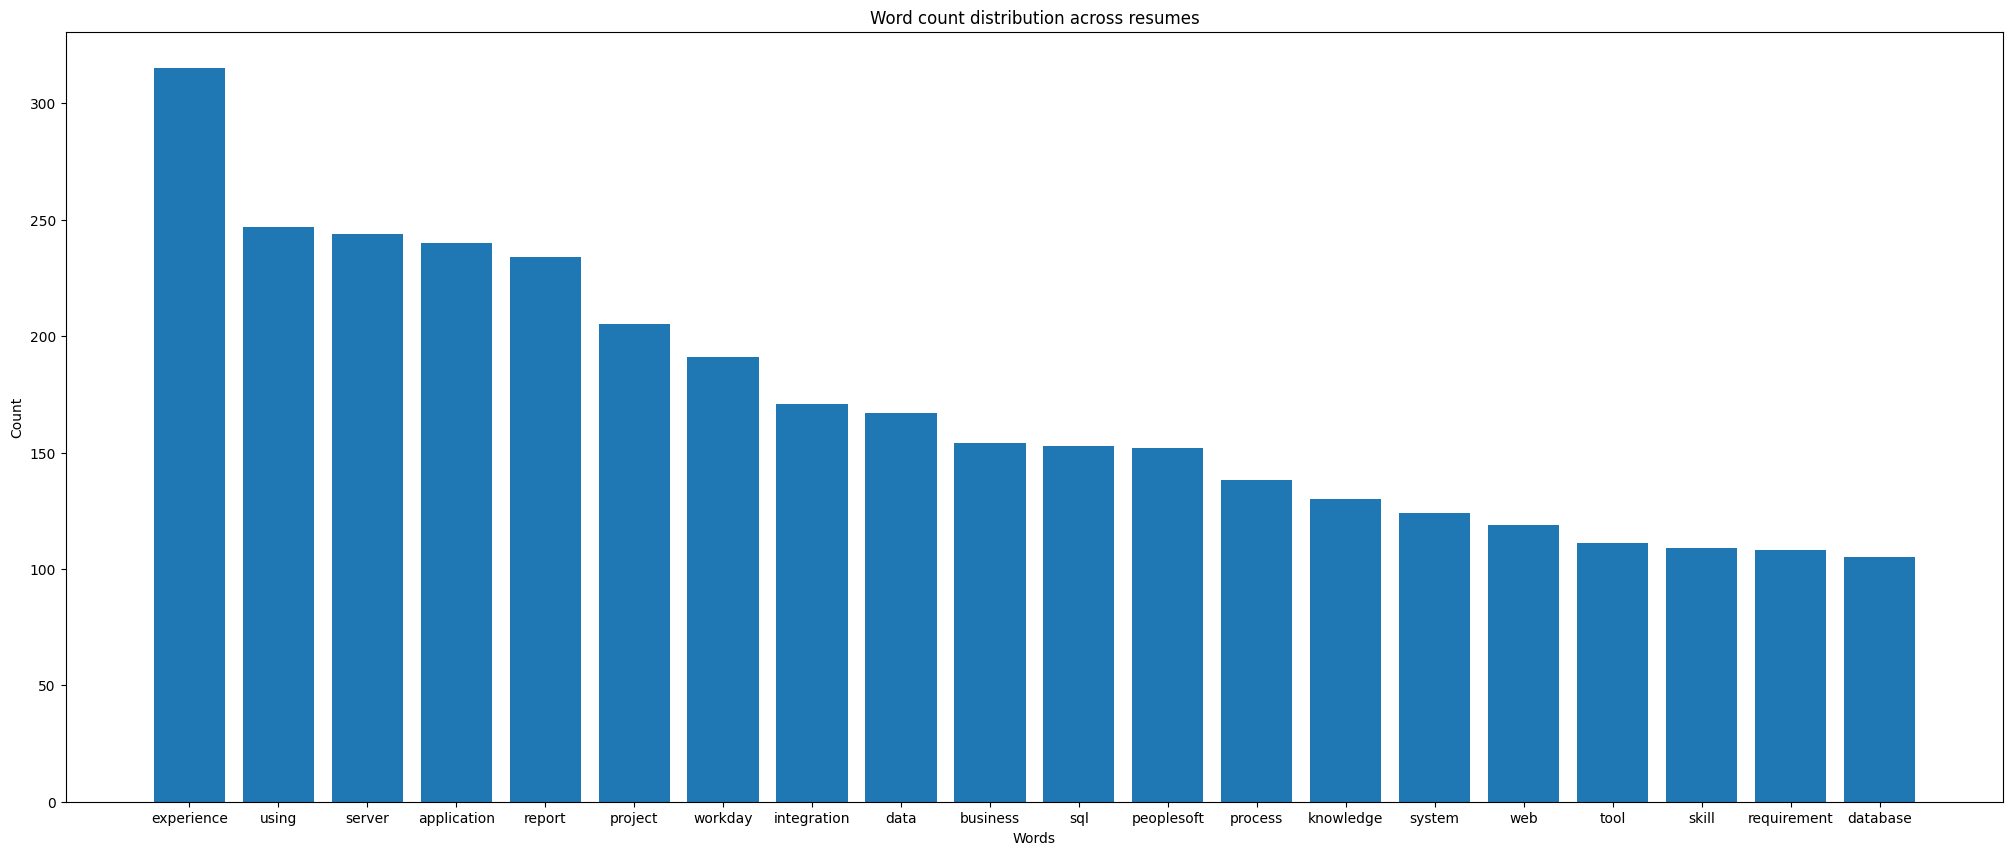

In [111]:
words = df_words_frequency['Words']
wordscount = df_words_frequency['Count']
plt.figure(figsize=(25,10))
plt.bar(words,wordscount)
plt.title("Word count distribution across resumes")
plt.xlabel("Words")
plt.ylabel("Count")
plt.show()

### Word Cloud

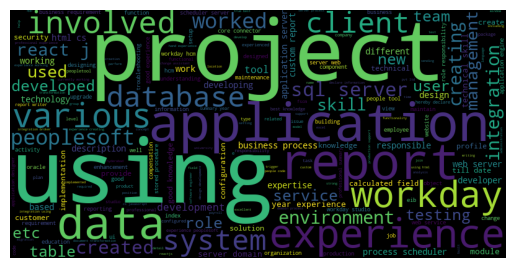

In [112]:
text = " ".join(df_cleaned['text'])
wc = WordCloud(width=800, height=400).generate(text)
plt.imshow(wc)
plt.axis("off")
plt.show()

### Named Entity Recognition using Spacy

In [113]:
nlp = spacy.load("en_core_web_sm")
doc = nlp(" ".join(df_cleaned['text'].sample(5)))
[(ent.text, ent.label_) for ent in doc.ents]

[('pavana kumari professional', 'PERSON'),
 ('pvt ltd bangalore', 'ORG'),
 ('mpc narayana junior college hyderabad', 'ORG'),
 ('vardhana', 'GPE'),
 ('microsoft', 'ORG'),
 ('american', 'NORP'),
 ('medicare', 'ORG'),
 ('one', 'CARDINAL'),
 ('kumari year', 'DATE'),
 ('india', 'GPE'),
 ('june', 'DATE'),
 ('hcm oracle window technical', 'ORG'),
 ('india', 'GPE'),
 ('verizon wireless development client verizon responsibility', 'ORG'),
 ('hsbc hyderabad', 'ORG'),
 ('india', 'GPE'),
 ('hsbc upgrade project client hsbc bank responsibility analysis understand',
  'ORG'),
 ('hcm db', 'PERSON'),
 ('mareedu lokesh babu', 'PERSON'),
 ('cs javascript jquery php mysql', 'PERSON'),
 ('node', 'GPE'),
 ('gudiwada', 'PERSON'),
 ('jntuk technical skill', 'ORG'),
 ('node', 'GPE'),
 ('xampp', 'GPE'),
 ('weekly', 'DATE'),
 ('august', 'DATE'),
 ('mareedu lokesh babu', 'PERSON'),
 ('year month', 'DATE'),
 ('year', 'DATE'),
 ('august', 'DATE'),
 ('oct', 'CARDINAL'),
 ('english', 'LANGUAGE'),
 ('kumar singh', 'PE

### Skills Extraction

In [114]:
skills_list = [
    'react','reactjs','javascript','html','css','python','django','flask','node','nodejs',
    'sql','mysql','postgresql','mongodb','aws','azure','docker','kubernetes','git'
]

def extract_skills(text, skills=skills_list):
    text = " " + (text or "") + " "
    found = [s for s in skills if f" {s} " in text or s in text]
    return sorted(set(found))

df_cleaned['skills'] = df_cleaned['text'].apply(extract_skills)
df_cleaned['skills_count'] = df_cleaned['skills'].apply(len)
df_cleaned.iloc[:, [0,4,5]]  # Display selected columns

,filename,skills,skills_count
0,Internship_Ravali_Musquare Technologies (1).docx,[],0
1,Internship_Susovan Bag_Musquare Technologies.docx,"[css, html, javascript, sql]",4
2,React Developer_Deepakreddy.docx,"[html, javascript, react, reactjs]",4
3,React Developer_Haripriya.docx,"[html, javascript, mysql, react, reactjs, sql]",6
4,React Developer_Kamalakar Reddy.docx,"[git, html, javascript, react, reactjs]",5
5,React Developer_Naveen sadhu.docx,"[css, html, node, nodejs, react, reactjs, sql]",7
6,React Developer_Pragnya.docx,"[html, javascript, react]",3
7,React Developer_Sarala Madasu-converted.docx,"[css, html, javascript, react]",4
8,React Developer_Thirupathiamma.docx,"[javascript, react]",2
9,React Dev_Krishna Kanth.docx,"[git, html, javascript, node, nodejs, react, r...",7


In [115]:
# Listing the most common skills
skill_counts = Counter([s for sub in df_cleaned['skills'] for s in sub])
pd.DataFrame(skill_counts.most_common(15), columns=['skill','count'])

,skill,count
0,sql,24
1,react,19
2,html,18
3,javascript,16
4,reactjs,10
5,node,10
6,mysql,8
7,git,8
8,aws,4
9,css,3


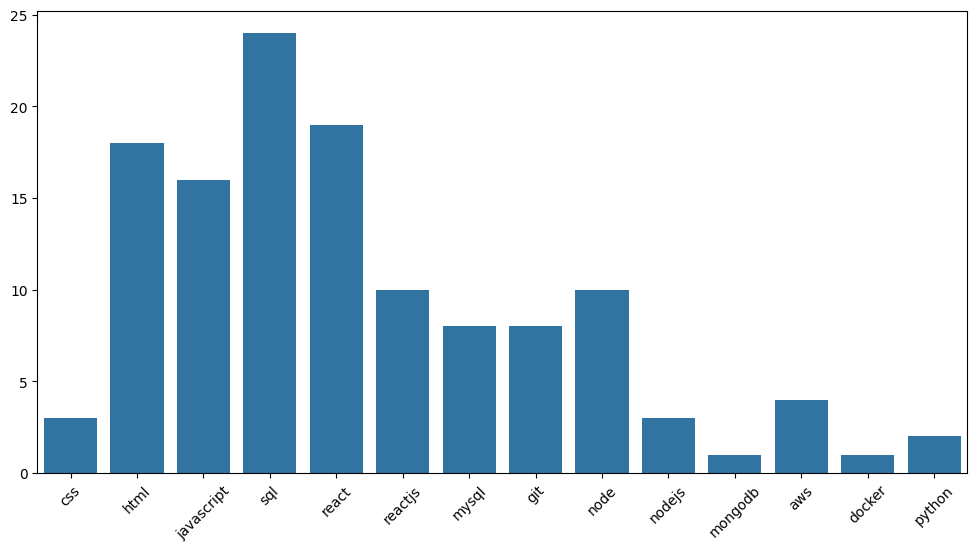

In [116]:
# Plotting skills distribution
plt.figure(figsize=(12,6))
sns.barplot(x=list(skill_counts.keys()), y=list(skill_counts.values()))
plt.xticks(rotation=45)
plt.show()


## Model Buidling

### Model 1: Naive Bayes

#### Defining and extracting variables

In [117]:
# Filterwanings import warnings
import warnings
warnings.filterwarnings("ignore")

In [118]:
# Assign labels - internship', 'react developer', 'react dev', 'react js developer','reactjs developer', 'peoplesoft admin', 'peoplesoft dba','peoplesoft fscm',
def extract_label(filename):
    fname = filename.lower()
    # normalize separators to spaces for easier matching
    fname_clean = re.sub(r'[_\-\.\(\)\[\]]+', ' ', fname)
    patterns = [
        'internship',
        'react js developer',
        'reactjs developer',
        'react developer',
        'react dev',
        'peoplesoft fscm',
        'peoplesoft dba',
        'peoplesoft admin'
    ]
    label = 'others'
    for p in patterns:
        if p in fname_clean:
            label = p
            break
    return label
df_cleaned['label'] = df_cleaned['filename'].apply(extract_label)
df_cleaned['label'].unique()

array(['internship', 'react developer', 'react dev', 'react js developer',
       'reactjs developer', 'peoplesoft admin', 'peoplesoft dba',
       'peoplesoft fscm', 'others'], dtype=object)

In [119]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(df_cleaned['text'], df_cleaned['label'], test_size=0.2, random_state=42)

In [120]:
# Text Verctorization using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(1,2))
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)  

Accuracy: 45.45%
Classification Report:
                    precision    recall  f1-score   support

            others       0.45      1.00      0.62         5
   react developer       0.00      0.00      0.00         2
react js developer       0.00      0.00      0.00         1
 reactjs developer       0.00      0.00      0.00         3

          accuracy                           0.45        11
         macro avg       0.11      0.25      0.16        11
      weighted avg       0.21      0.45      0.28        11

Confusion Matrix:


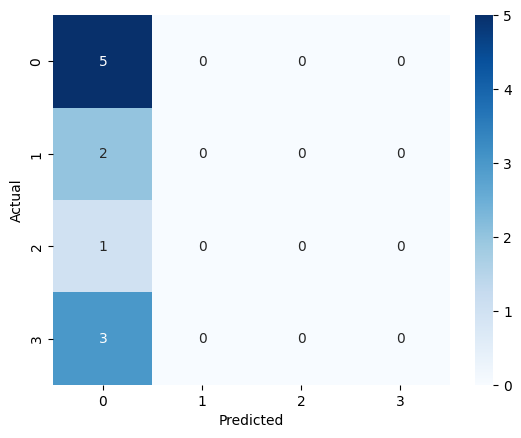

In [121]:
# Train Naive Bayes Classifier
model = MultinomialNB()
model.fit(X_train, y_train) 

# Predict on test set
y_pred = model.predict(X_test)  

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)   
print(f"Accuracy: {accuracy*100:.2f}%")
print("Classification Report:")

print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  
plt.xlabel('Predicted')
plt.ylabel('Actual')        
plt.show()

#### Hyperparameter tuning for Naive Bayes

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best params: {'chi2__k': 2000, 'clf': ComplementNB(), 'clf__alpha': 0.1, 'tfidf__max_df': 0.9, 'tfidf__max_features': 5000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1)}
Accuracy: 72.73%
                    precision    recall  f1-score   support

            others       0.83      1.00      0.91         5
   react developer       1.00      0.50      0.67         2
react js developer       0.00      0.00      0.00         1
 reactjs developer       0.50      0.67      0.57         3

          accuracy                           0.73        11
         macro avg       0.58      0.54      0.54        11
      weighted avg       0.70      0.73      0.69        11



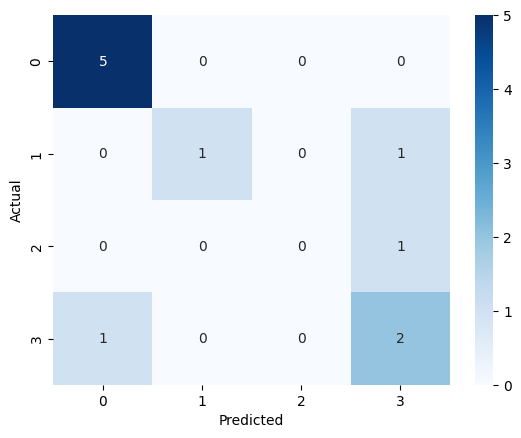

In [122]:

# 1) split raw texts (stratify to preserve label distribution)
X_text_train, X_text_test, y_train, y_test = train_test_split(
    df_cleaned['text'], df_cleaned['label'],
    test_size=0.2, random_state=42
)

# 2) pipeline: TF-IDF -> optional chi2 feature selection -> classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(sublinear_tf=True, lowercase=True)),
    ('chi2', SelectKBest(chi2)),   # keep as step for tuning; can be removed to speed up
    ('clf', MultinomialNB())
])

# 3) grid for TF-IDF, chi2 and different classifiers
param_grid = [
    # MultinomialNB / ComplementNB grid
    {
        'tfidf__ngram_range': [(1,1),(1,2)],
        'tfidf__max_df': [0.9, 1.0],
        'tfidf__min_df': [1, 2],
        'tfidf__max_features': [5000, 10000],
        'chi2__k': [2000, 3000],
        'clf': [MultinomialNB()],
        'clf__alpha': [0.1, 0.5, 1.0]
    },
    {
        'tfidf__ngram_range': [(1,1),(1,2)],
        'tfidf__max_df': [0.9, 1.0],
        'tfidf__min_df': [1, 2],
        'tfidf__max_features': [5000, 10000],
        'chi2__k': [2000, 3000],
        'clf': [ComplementNB()],
        'clf__alpha': [0.1, 0.5, 1.0]
    },
    # linear SVM
    {
        'tfidf__ngram_range': [(1,1),(1,2)],
        'tfidf__max_df': [0.9, 1.0],
        'tfidf__min_df': [1, 2],
        'tfidf__max_features': [5000, 10000],
        'chi2__k': [2000, 3000],
        'clf': [LinearSVC(max_iter=10000)],
        'clf__C': [0.1, 1, 10]
    }
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(pipeline, param_grid, cv=cv, scoring='f1_weighted', n_jobs=-1, verbose=2)

# 4) fit search on training split
gs.fit(X_text_train, y_train)

print("Best params:", gs.best_params_)
best = gs.best_estimator_

# 5) evaluate on test split
y_pred = best.predict(X_text_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")
print(classification_report(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.show()



#### Feature importances (top 20) after TF-IDF vectorizer with Hyperparamter tuning

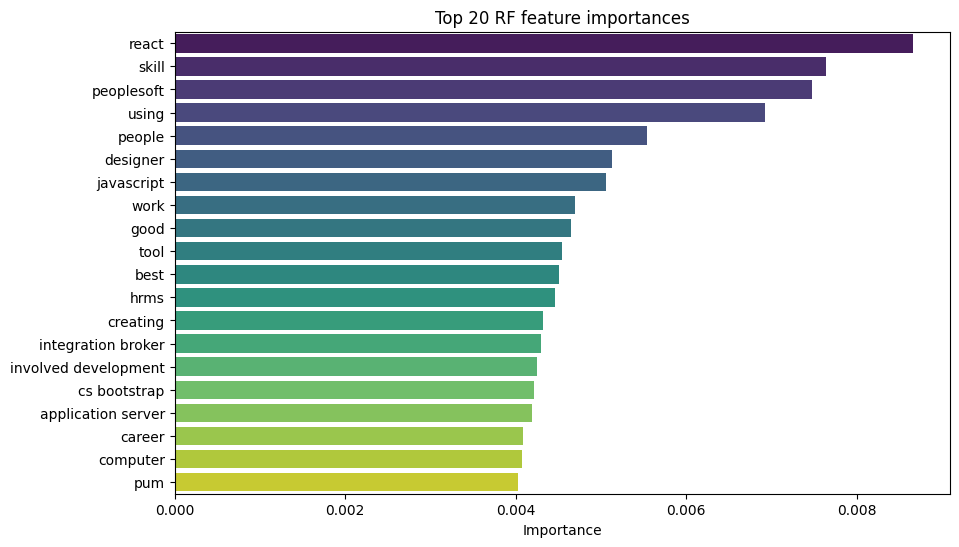

In [123]:

try:
    if 'vectorizer' in globals():
        fnames = vectorizer.get_feature_names_out()
    elif 'best' in globals() and hasattr(best, 'named_steps') and 'tfidf' in best.named_steps:
        fnames = best.named_steps['tfidf'].get_feature_names_out()
    else:
        fnames = None
except Exception:
    fnames = None

if fnames is not None:
    importances = rf.feature_importances_
    idx = np.argsort(importances)[-20:][::-1]
    top_feats = fnames[idx]
    top_imps = importances[idx]
    plt.figure(figsize=(10,6))
    sns.barplot(x=top_imps, y=top_feats, palette='viridis')
    plt.xlabel('Importance'); plt.title('Top 20 RF feature importances'); plt.show()
else:
    print("Feature names unavailable — cannot plot importances.")

#### ROC Curve for Naive Bayes 

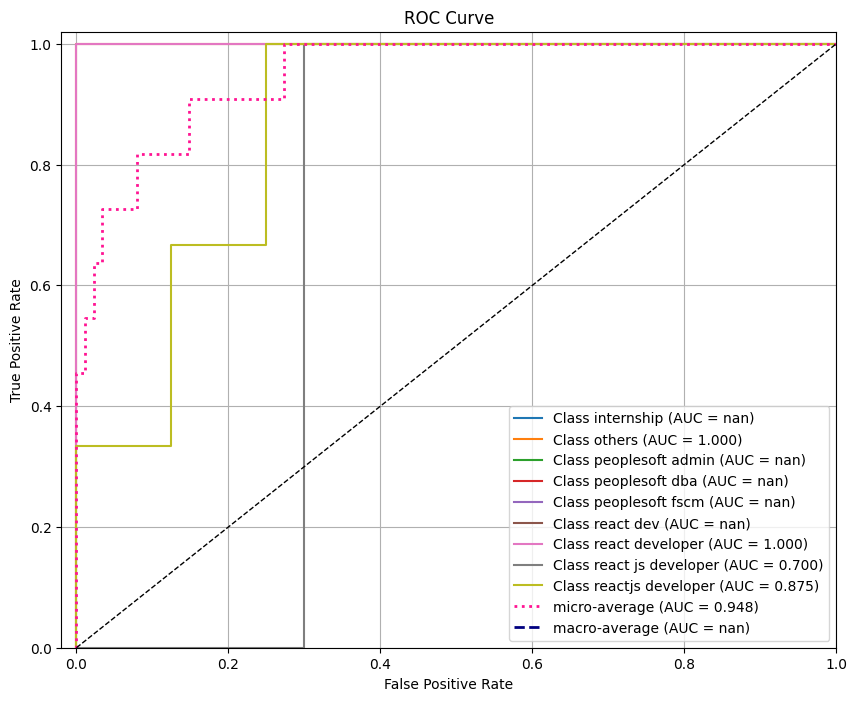

In [124]:
# get prediction scores
try:
    y_score = best.predict_proba(X_text_test)
except Exception:
    # some classifiers (LinearSVC) don't have predict_proba but have decision_function
    y_score = best.decision_function(X_text_test)

# prepare true labels
classes = list(best.classes_)
y_test_array = np.array(y_test)
Y = label_binarize(y_test_array, classes=classes)
n_classes = Y.shape[1]

plt.figure(figsize=(10, 8))

# Binary case: y_score may be 1D or (n_samples,2)
if y_score.ndim == 1 or (y_score.ndim == 2 and y_score.shape[1] == 1):
    # single score per sample (binary)
    scores = y_score.ravel()
    fpr, tpr, _ = roc_curve(y_test_array == classes[1] if len(classes)>1 else y_test_array, scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.3f})')
else:
    # Multiclass: compute per-class ROC and AUC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i, cls in enumerate(classes):
        fpr[i], tpr[i], _ = roc_curve(Y[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=1.5, label=f'Class {cls} (AUC = {roc_auc[i]:.3f})')

    # micro-average
    fpr["micro"], tpr["micro"], _ = roc_curve(Y.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=2,
             label=f'micro-average (AUC = {roc_auc["micro"]:.3f})')

    # macro-average
    # aggregate all fpr points
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    plt.plot(fpr["macro"], tpr["macro"], color='navy', linestyle='--', linewidth=2,
             label=f'macro-average (AUC = {roc_auc["macro"]:.3f})')

# plot chance line and formatting
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


### Model 2: Random Forest with ROC curve

Random Forest Accuracy: 54.55%
                    precision    recall  f1-score   support

            others       0.62      1.00      0.77         5
   react developer       0.33      0.50      0.40         2
react js developer       0.00      0.00      0.00         1
 reactjs developer       0.00      0.00      0.00         3

          accuracy                           0.55        11
         macro avg       0.24      0.38      0.29        11
      weighted avg       0.34      0.55      0.42        11



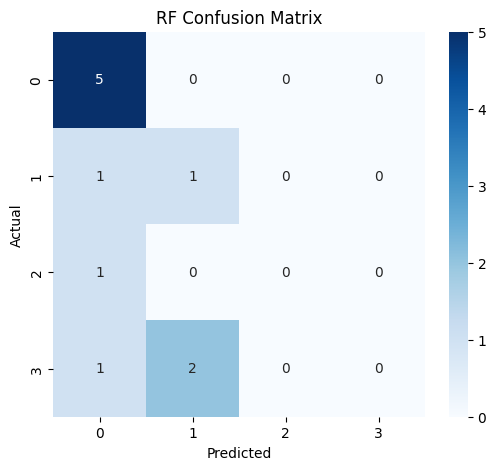

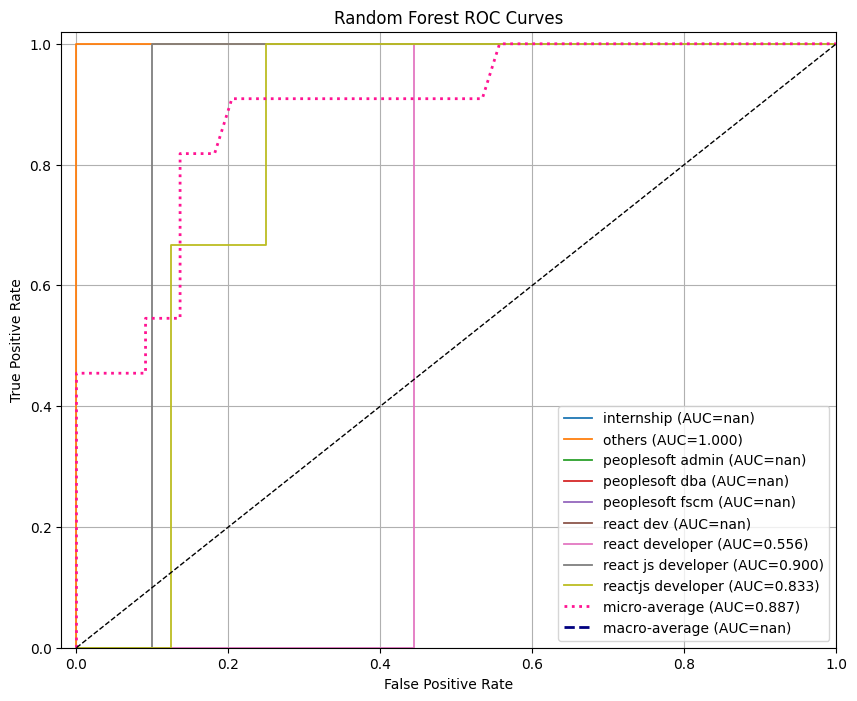

In [125]:
# Train Random Forest (adjust n_estimators / max_depth as needed)
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

# Predictions & evaluation
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {acc_rf*100:.2f}%")
print(classification_report(y_test, y_pred_rf, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('RF Confusion Matrix')
plt.show()

# ROC / AUC (multiclass: per-class, micro and macro)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
try:
    y_score_rf = rf.predict_proba(X_test)
except Exception:
    # fallback (shouldn't be needed for RandomForest, but safe)
    y_score_rf = rf.decision_function(X_test)

classes = list(rf.classes_)
y_test_array = np.array(y_test)
Y = label_binarize(y_test_array, classes=classes)
if Y.shape[1] == 0:
    print("ROC: label binarize failed (check labels).")
else:
    n_classes = Y.shape[1]
    plt.figure(figsize=(10,8))

    # per-class
    fpr = dict(); tpr = dict(); roc_auc = dict()
    for i, cls in enumerate(classes):
        fpr[i], tpr[i], _ = roc_curve(Y[:, i], y_score_rf[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=1.3, label=f'{cls} (AUC={roc_auc[i]:.3f})')

    # micro-average
    fpr["micro"], tpr["micro"], _ = roc_curve(Y.ravel(), y_score_rf.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=2,
             label=f'micro-average (AUC={roc_auc["micro"]:.3f})')

    # macro-average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    plt.plot(fpr["macro"], tpr["macro"], color='navy', linestyle='--', linewidth=2,
             label=f'macro-average (AUC={roc_auc["macro"]:.3f})')

    plt.plot([0,1],[0,1],'k--', lw=1)
    plt.xlim([-0.02,1.0]); plt.ylim([0.0,1.02])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('Random Forest ROC Curves')
    plt.legend(loc='lower right'); plt.grid(True); plt.show()

### Model 3: Gradient Boosting with ROC curve

Gradient Boosting Accuracy: 63.64%
                    precision    recall  f1-score   support

            others       1.00      1.00      1.00         5
         react dev       0.00      0.00      0.00         0
   react developer       0.33      0.50      0.40         2
react js developer       0.00      0.00      0.00         1
 reactjs developer       0.50      0.33      0.40         3

          accuracy                           0.64        11
         macro avg       0.37      0.37      0.36        11
      weighted avg       0.65      0.64      0.64        11



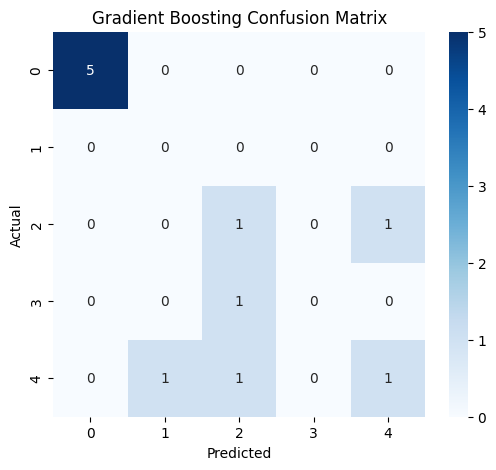

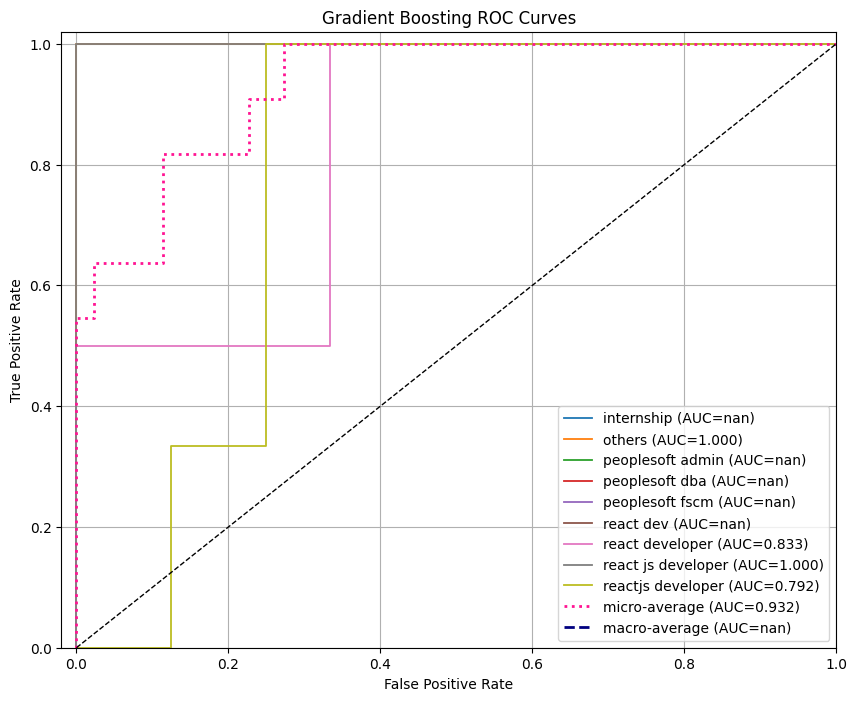

In [126]:
# Train Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
# some sklearn GB implementations may not accept sparse matrices -> convert if needed
try:
    gb.fit(X_train, y_train)
except Exception:
    gb.fit(X_train.toarray(), y_train)

# Predictions and evaluation
try:
    y_pred_gb = gb.predict(X_test)
except Exception:
    y_pred_gb = gb.predict(X_test.toarray())

acc_gb = accuracy_score(y_test, y_pred_gb)
print(f"Gradient Boosting Accuracy: {acc_gb*100:.2f}%")
print(classification_report(y_test, y_pred_gb, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Gradient Boosting Confusion Matrix')
plt.show()

# ROC / AUC (multiclass: per-class, micro and macro)
try:
    y_score_gb = gb.predict_proba(X_test)
except Exception:
    y_score_gb = gb.predict_proba(X_test.toarray())

classes = list(gb.classes_)
y_test_array = np.array(y_test)
Y = label_binarize(y_test_array, classes=classes)
if Y.shape[1] == 0:
    print("ROC: label binarize failed (check labels).")
else:
    n_classes = Y.shape[1]
    plt.figure(figsize=(10,8))

    fpr = dict(); tpr = dict(); roc_auc = dict()
    for i, cls in enumerate(classes):
        fpr[i], tpr[i], _ = roc_curve(Y[:, i], y_score_gb[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=1.3, label=f'{cls} (AUC={roc_auc[i]:.3f})')

    # micro-average
    fpr["micro"], tpr["micro"], _ = roc_curve(Y.ravel(), y_score_gb.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=2,
             label=f'micro-average (AUC={roc_auc["micro"]:.3f})')

    # macro-average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    plt.plot(fpr["macro"], tpr["macro"], color='navy', linestyle='--', linewidth=2,
             label=f'macro-average (AUC={roc_auc["macro"]:.3f})')

    plt.plot([0,1],[0,1],'k--', lw=1)
    plt.xlim([-0.02,1.0]); plt.ylim([0.0,1.02])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('Gradient Boosting ROC Curves')
    plt.legend(loc='lower right'); plt.grid(True); plt.show()

### Model 4: K-Means with Silhouette Score

Cluster sizes:
0     2
1    11
2     5
3    15
4     1
5    10
6     2
7     6
8     1
Name: count, dtype: int64

Contingency table (labels vs clusters):
col_0               0   1  2  3  4   5  6  7  8
label                                          
internship          1   0  0  1  0   0  0  0  0
others              1  11  0  0  0  10  0  0  0
peoplesoft admin    0   0  4  0  0   0  0  0  0
peoplesoft dba      0   0  1  0  0   0  0  0  0
peoplesoft fscm     0   0  0  3  1   0  0  0  1
react dev           0   0  0  0  0   0  0  2  0
react developer     0   0  0  5  0   0  0  2  0
react js developer  0   0  0  2  0   0  0  0  0
reactjs developer   0   0  0  4  0   0  2  2  0

Silhouette score: 0.1128

Top terms per cluster:
Cluster 0: good knowledge, knowledge, good, testing, workday, testing good, plan, meeting, job, process
Cluster 1: sql, sql server, server, table, database, data, index, query, function, experience
Cluster 2: server, peoplesoft, application, application server, schedu

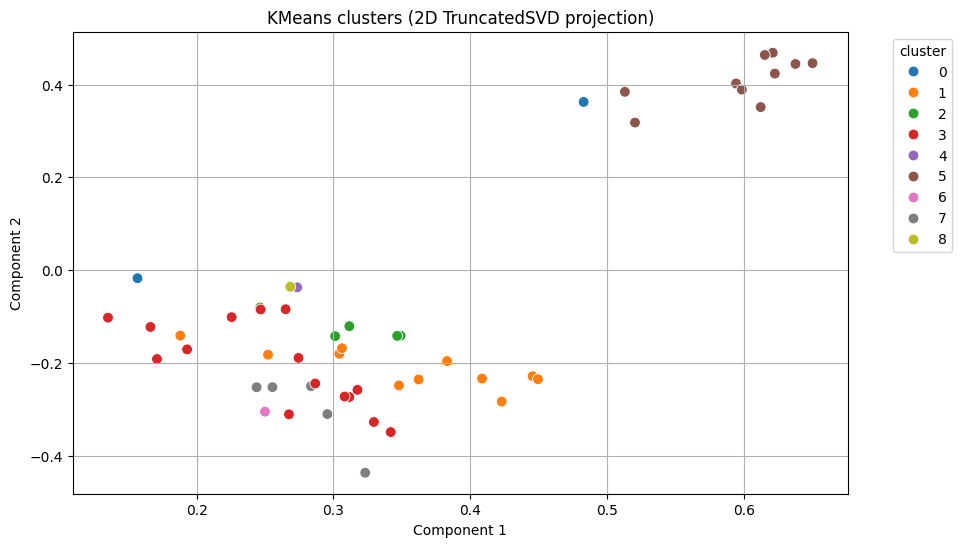

In [127]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Build TF-IDF for all documents (vectorizer already fitted)
X_all = vectorizer.transform(df_cleaned['text'])

# Choose clusters = number of known labels (or set manually)
n_clusters = max(2, df_cleaned['label'].nunique())

# Fit MiniBatchKMeans (works with sparse TF-IDF)
km = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=100)
km.fit(X_all)
cluster_ids = km.labels_

# Basic cluster diagnostics
print("Cluster sizes:")
print(pd.Series(cluster_ids).value_counts().sort_index())

# Compare clusters to ground-truth labels
print("\nContingency table (labels vs clusters):")
print(pd.crosstab(df_cleaned['label'], cluster_ids))

# Silhouette score (sampled for speed if dataset is large)
try:
    sil = silhouette_score(X_all, cluster_ids, sample_size=min(1000, X_all.shape[0]), random_state=42)
    print(f"\nSilhouette score: {sil:.4f}")
except Exception as e:
    print("Silhouette score computation failed:", e)

# Top terms per cluster
try:
    terms = vectorizer.get_feature_names_out()
    centers = km.cluster_centers_
    order = centers.argsort()[:, ::-1]
    print("\nTop terms per cluster:")
    for i in range(n_clusters):
        top_terms = [terms[idx] for idx in order[i, :10]]
        print(f"Cluster {i}: {', '.join(top_terms)}")
except Exception as e:
    print("Top-terms extraction failed:", e)

# 2D visualization using TruncatedSVD (works with sparse matrices)
svd = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd.fit_transform(X_all)

plt.figure(figsize=(10,6))
palette = sns.color_palette("tab10", n_clusters)
sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=cluster_ids, palette=palette, legend='full', s=60)
plt.title('KMeans clusters (2D TruncatedSVD projection)')
plt.xlabel('Component 1'); plt.ylabel('Component 2')
plt.legend(title='cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# Optionally add cluster id back to dataframe
df_cleaned['km_cluster'] = cluster_ids
# ...existing code...

### Model comparison based on F1 score

                  accuracy  f1_weighted
model                                  
NaiveBayes        0.727273     0.690279
RandomForest      0.545455     0.422378
GradientBoosting  0.636364     0.636364
KMeans            0.727273     0.636364


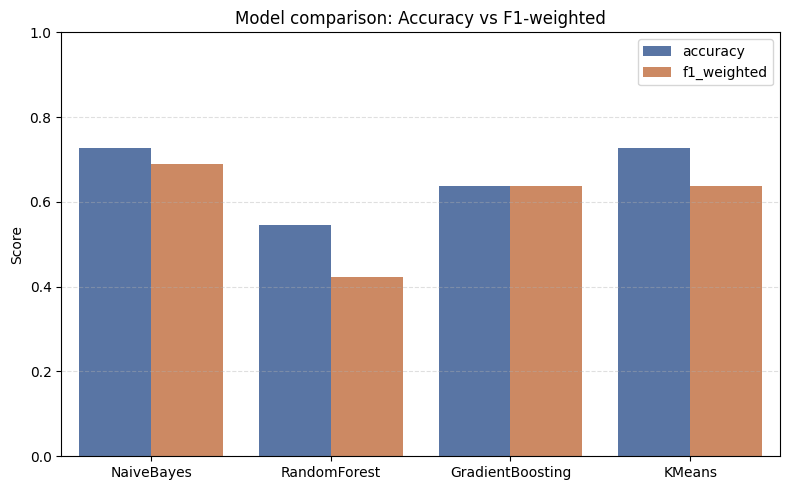

Best model by F1-weighted: NaiveBayes (F1=0.690)
Naive Bayes selected because it gave best F1; it performs well on text (multinomial) with TF-IDF


In [128]:
# Ensure supervised models predictions exist; compute if not
y_pred_nb = model.predict(X_test) if 'y_pred' not in globals() else y_pred
y_pred_rf = rf.predict(X_test) if 'y_pred_rf' not in globals() else y_pred_rf
y_pred_gb = gb.predict(X_test) if 'y_pred_gb' not in globals() else y_pred_gb

# Metrics for supervised models
scores = []
for name, ypred in [('NaiveBayes', y_pred_nb), ('RandomForest', y_pred_rf), ('GradientBoosting', y_pred_gb)]:
    acc = accuracy_score(y_test, ypred)
    f1w = f1_score(y_test, ypred, average='weighted', zero_division=0)
    scores.append({'model': name, 'accuracy': acc, 'f1_weighted': f1w})

# KMeans (train on X_train, predict on X_test, map clusters -> most common train label)
n_clusters = max(2, df_cleaned['label'].nunique())
km = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=100)
# fit may fail on sparse -> convert to dense if needed
try:
    km.fit(X_train)
    train_clusters = km.predict(X_train)
    test_clusters = km.predict(X_test)
except Exception:
    km.fit(X_train.toarray())
    train_clusters = km.predict(X_train.toarray())
    test_clusters = km.predict(X_test.toarray())

# build mapping cluster -> most common label in training set
cluster_label_map = {}
for c in np.unique(train_clusters):
    labels_in_cluster = np.array(y_train)[train_clusters == c]
    if labels_in_cluster.size == 0:
        continue
    most_common = Counter(labels_in_cluster).most_common(1)[0][0]
    cluster_label_map[c] = most_common

# map test clusters to predicted labels (fallback to 'others' if unknown)
y_pred_km = [cluster_label_map.get(c, 'others') for c in test_clusters]

acc_km = accuracy_score(y_test, y_pred_km)
f1w_km = f1_score(y_test, y_pred_km, average='weighted', zero_division=0)
scores.append({'model': 'KMeans', 'accuracy': acc_km, 'f1_weighted': f1w_km})

# Results dataframe
df_scores = pd.DataFrame(scores).set_index('model')
print(df_scores)

# Plot comparison (accuracy and f1_weighted)
df_plot = df_scores.reset_index().melt(id_vars='model', value_vars=['accuracy', 'f1_weighted'],
                                       var_name='metric', value_name='score')

plt.figure(figsize=(8,5))
sns.barplot(data=df_plot, x='model', y='score', hue='metric', palette='deep')
plt.title('Model comparison: Accuracy vs F1-weighted')
plt.ylim(0,1)
plt.ylabel('Score')
plt.xlabel('')
plt.legend(title='')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# Choose best by f1_weighted and short inference
best = df_scores['f1_weighted'].idxmax()
print(f"Best model by F1-weighted: {best} (F1={df_scores.loc[best,'f1_weighted']:.3f})")

# Short inference (printed)
if best in ['RandomForest', 'GradientBoosting']:
    print(f"{best} selected because it achieved the highest weighted F1. Ensemble tree models")
    print("handle high-dimensional TF-IDF features, capture non-linear patterns and are robust to noisy")
    print("features and class imbalance (with class_weight or ensemble averaging).")
elif best == 'NaiveBayes':
    print("Naive Bayes selected because it gave best F1; it performs well on text (multinomial) with TF-IDF")
else:
    print("KMeans (unsupervised) performed best by this metric — verify supervised comparison and labels.")


## Save model for deployment

In [130]:
joblib.dump(best, 'best_resume_model.joblib')

['best_resume_model.joblib']

Deployment using Streamlit

In [131]:
import io
import os
import re
import string
import zipfile
import numpy as np
import pandas as pd
import streamlit as st
import joblib
from bs4 import BeautifulSoup
from PyPDF2 import PdfReader
from docx import Document
from sklearn.pipeline import Pipeline

# ---------- File readers ----------
def read_pdf(file_bytes):
    reader = PdfReader(io.BytesIO(file_bytes))
    text = ""
    for p in reader.pages:
        text += p.extract_text() or ""
    return text

def read_docx(file_bytes):
    doc = Document(io.BytesIO(file_bytes))
    return "\n".join([p.text for p in doc.paragraphs])

def read_txt(file_bytes):
    try:
        return file_bytes.decode('utf-8', errors='ignore')
    except Exception:
        return str(file_bytes)

def extract_text_from_file(file_name, file_bytes):
    ext = os.path.splitext(file_name)[1].lower()
    if ext == ".pdf":
        return read_pdf(file_bytes)
    elif ext in (".docx", ".doc"):
        return read_docx(file_bytes)
    elif ext in (".txt", ".rtf"):
        return read_txt(file_bytes)
    else:
        return ""

def extract_zip_bytes(zip_bytes):
    texts = {}
    with zipfile.ZipFile(io.BytesIO(zip_bytes)) as z:
        for info in z.infolist():
            if info.is_dir():
                continue
            name = info.filename
            try:
                b = z.read(name)
                txt = extract_text_from_file(name, b)
                if txt:
                    texts[name] = txt
            except Exception:
                continue
    return texts

# ---------- Cleaning ----------
def remove_html(text):
    return BeautifulSoup(text or "", "html.parser").get_text(separator=" ")

def remove_urls_emails(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    return text

def remove_punc_numbers(text):
    text = re.sub(r'\d+', '', text)
    return text.translate(str.maketrans('', '', string.punctuation))

DEFAULT_STOPWORDS = set("""
a about above after again against all am an and any are aren't as at be because been before being below between both
but by could couldn't did didn't do does doesn't doing don't down during each few for from further had hadn't has
hasn't have haven't having he he'd he'll he's her here here's hers herself him himself his how how's i i'd i'll i'm
i've if in into is isn't it it's its itself let's me more most mustn't my myself no nor not of off on once only or
other ought our ours ourselves out over own same shan't she she'd she'll she's should shouldn't so some such than that
that's the their theirs them themselves then there there's these they they'd they'll they're they've this those through
to too under until up very was wasn't we we'd we'll we're we've were weren't what what's when when's where where's
which while who who's whom why why's with won't would wouldn't you you'd you'll you're you've your yours yourself yourselves
""".split())

def clean_text(text):
    text = remove_html(text)
    text = text.lower()
    text = remove_urls_emails(text)
    text = remove_punc_numbers(text)
    tokens = [t.strip() for t in text.split() if t.strip() and t not in DEFAULT_STOPWORDS]
    return " ".join(tokens)

# ---------- Skills extractor (optional) ----------
SKILLS = [
    'react','reactjs','javascript','html','css','python','django','flask','node','nodejs',
    'sql','mysql','postgresql','mongodb','aws','azure','docker','kubernetes','git'
]
def extract_skills(text, skills=SKILLS):
    t = " " + (text or "") + " "
    found = [s for s in skills if f" {s} " in t or s in t]
    return sorted(set(found))

# ---------- Model selection / loading ----------
@st.cache_resource
def pick_model(joblib_paths=("best_resume_model.joblib","best_model.joblib")):
    # 1) If running inside the same notebook/session, prefer gs.best_estimator_ then pipeline or compose vectorizer+model
    try:
        g = globals()
        # prefer GridSearchCV .best_estimator_
        if 'gs' in g and hasattr(g['gs'], "best_estimator_"):
            return g['gs'].best_estimator_, "gs.best_estimator_"
        if 'pipeline' in g and isinstance(g['pipeline'], Pipeline):
            return g['pipeline'], "pipeline"
        # if raw classifier + vectorizer exist, compose a pipeline
        if 'vectorizer' in g and 'model' in g:
            try:
                composed = Pipeline([('tfidf', g['vectorizer']), ('clf', g['model'])])
                return composed, "composed(vectorizer+model)"
            except Exception:
                pass
    except Exception:
        pass
    # 2) Fallback: try load joblib model files from disk
    for p in joblib_paths:
        if os.path.exists(p):
            try:
                m = joblib.load(p)
                return m, f"joblib:{p}"
            except Exception:
                continue
    return None, None

model, model_source = pick_model()

def get_proba_or_scores(estimator, texts):
    try:
        proba = estimator.predict_proba(texts)
        return proba, estimator.classes_
    except Exception:
        try:
            scores = estimator.decision_function(texts)
            if scores.ndim == 1:
                scores = np.vstack([-scores, scores]).T
            exp = np.exp(scores - np.max(scores, axis=1, keepdims=True))
            proba = exp / exp.sum(axis=1, keepdims=True)
            classes = estimator.classes_ if hasattr(estimator, 'classes_') else np.arange(proba.shape[1])
            return proba, classes
        except Exception:
            preds = estimator.predict(texts)
            classes = estimator.classes_ if hasattr(estimator, 'classes_') else np.unique(preds)
            proba = np.zeros((len(texts), len(classes)))
            cls_to_idx = {c:i for i,c in enumerate(classes)}
            for i,p in enumerate(preds):
                proba[i, cls_to_idx[p]] = 1.0
            return proba, classes

# ---------- Streamlit UI ----------
st.set_page_config(page_title="Resume Classifier", layout="wide")
st.title("Resume Classifier (Notebook / Joblib aware)")

col1, col2 = st.columns([2,1])
with col1:
    uploaded = st.file_uploader("Upload resume (pdf/docx/txt) or zip", type=['pdf','docx','doc','txt','zip'])
    manual_text = st.text_area("Or paste resume text here", height=200)
    run_btn = st.button("Classify")
with col2:
    st.header("Model")
    if model is None:
        st.error("No model found in session or joblib. Place trained pipeline or joblib model next to app.")
    else:
        st.success(f"Loaded model ({model_source}): {type(model).__name__}")
        if hasattr(model, 'named_steps'):
            st.write("Pipeline steps:", list(model.named_steps.keys()))
    st.markdown("Top skills (searches):")
    st.write(", ".join(SKILLS))

def process_texts(texts_dict):
    rows = []
    texts = []
    fnames = []
    for fname, raw in texts_dict.items():
        cleaned = clean_text(raw)
        skills = extract_skills(cleaned)
        fnames.append(fname)
        texts.append(cleaned)
        rows.append({'file': fname, 'cleaned': cleaned[:1000], 'skills': ", ".join(skills)})
    if model is None:
        return pd.DataFrame(rows)
    proba, classes = get_proba_or_scores(model, texts)
    for i, r in enumerate(rows):
        pred_idx = int(np.argmax(proba[i]))
        r['predicted'] = classes[pred_idx]
        top_n = min(3, proba.shape[1])
        inds = np.argsort(proba[i])[::-1][:top_n]
        r['top_probs'] = ", ".join([f"{classes[j]}:{proba[i,j]:.3f}" for j in inds])
    return pd.DataFrame(rows)

if run_btn:
    texts_dict = {}
    if uploaded is not None:
        b = uploaded.read()
        if uploaded.type == "application/zip" or uploaded.name.lower().endswith(".zip"):
            texts_dict = extract_zip_bytes(b)
            if not texts_dict:
                st.warning("No readable resumes found inside ZIP.")
        else:
            txt = extract_text_from_file(uploaded.name, b)
            if not txt:
                st.warning("Could not extract text from uploaded file.")
            texts_dict[uploaded.name] = txt
    if manual_text:
        texts_dict["manual_input.txt"] = manual_text

    if not texts_dict:
        st.info("Please upload or paste text.")
    else:
        out = process_texts(texts_dict)
        st.subheader("Results")
        cols = ['file','predicted','top_probs','skills']
        present = [c for c in cols if c in out.columns]
        st.dataframe(out[present])
        if len(out) == 1:
            r = out.iloc[0]
            st.subheader("Detail")
            st.write("Predicted:", r.get('predicted',''))
            st.write("Top probs:", r.get('top_probs',''))
            st.write("Skills:", r.get('skills',''))
            st.text_area("Cleaned text", r.get('cleaned',''), height=300)

st.markdown("---")
st.write("Notes: this app tries to pick a best model from the running notebook (gs.best_estimator_, pipeline) or load a joblib model file. For production, save the full preprocessing+classifier pipeline with joblib and place it next to this app.")


2025-11-25 16:32:45.973 
  command:

    streamlit run c:\ProgramData\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-11-25 16:32:45.986 Session state does not function when running a script without `streamlit run`
